# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

In [1]:
# 라이브러리 버전 확인

import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 준비

In [2]:
# 데이터 준비

import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


데이터 라벨링 의문점 :  
2번에 '추천한다'는 코멘트가 있음에도 부정이라고 판단한 이유가 뭘까?

In [3]:
# 데이터 로더 구성

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #중복 데이터 삭제
    train_data = train_data.dropna(how = 'any')                   # 결측치 삭제
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 정규 표현식을 통한 한글 외 문자 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

/tmp/ipykernel_8712/2635819062.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
/tmp/ipykernel_8712/2635819062.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word)

{3: '', 4: '영화', 5: '다', 6: '고', 7: '하', 8: '을', 9: '보', 10: '게', 11: '지', 12: '있', 13: '없', 14: '좋', 15: '나', 16: '었', 17: '만', 18: '는데', 19: '너무', 20: '봤', 21: '적', 22: '안', 23: '정말', 24: '로', 25: '것', 26: '음', 27: '아', 28: '네요', 29: '어', 30: '재밌', 31: '지만', 32: '같', 33: '진짜', 34: '에서', 35: '했', 36: '기', 37: '네', 38: '않', 39: '점', 40: '거', 41: '았', 42: '수', 43: '되', 44: '면', 45: 'ㅋㅋ', 46: '인', 47: '말', 48: '연기', 49: '주', 50: '최고', 51: '내', 52: '평점', 53: '이런', 54: '던', 55: '어요', 56: '할', 57: '왜', 58: '겠', 59: '스토리', 60: '해', 61: 'ㅋㅋㅋ', 62: '습니다', 63: '듯', 64: '아니', 65: '드라마', 66: '생각', 67: '더', 68: '그', 69: '싶', 70: '사람', 71: '때', 72: '감동', 73: '배우', 74: '함', 75: '본', 76: '까지', 77: '뭐', 78: '알', 79: '만들', 80: '내용', 81: '볼', 82: '보다', 83: '감독', 84: '라', 85: '재미', 86: '그냥', 87: '시간', 88: '지루', 89: '중', 90: '재미있', 91: '였', 92: '잼', 93: '년', 94: '사랑', 95: '못', 96: '재미없', 97: '냐', 98: '쓰레기', 99: '서', 100: '라고', 101: '니', 102: '면서', 103: '다시', 104: '번', 105: '나오', 106: '하나', 107: '작품', 108:

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
word_to_index = {k:(v) for k,v in word_to_index.items()} # (v+3) -> v로 변경

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))

더 빙 진짜 짜증 나 네요 목소리


In [7]:
print(index_to_word)

{3: '<UNUSED>', 4: '영화', 5: '다', 6: '고', 7: '하', 8: '을', 9: '보', 10: '게', 11: '지', 12: '있', 13: '없', 14: '좋', 15: '나', 16: '었', 17: '만', 18: '는데', 19: '너무', 20: '봤', 21: '적', 22: '안', 23: '정말', 24: '로', 25: '것', 26: '음', 27: '아', 28: '네요', 29: '어', 30: '재밌', 31: '지만', 32: '같', 33: '진짜', 34: '에서', 35: '했', 36: '기', 37: '네', 38: '않', 39: '점', 40: '거', 41: '았', 42: '수', 43: '되', 44: '면', 45: 'ㅋㅋ', 46: '인', 47: '말', 48: '연기', 49: '주', 50: '최고', 51: '내', 52: '평점', 53: '이런', 54: '던', 55: '어요', 56: '할', 57: '왜', 58: '겠', 59: '스토리', 60: '해', 61: 'ㅋㅋㅋ', 62: '습니다', 63: '듯', 64: '아니', 65: '드라마', 66: '생각', 67: '더', 68: '그', 69: '싶', 70: '사람', 71: '때', 72: '감동', 73: '배우', 74: '함', 75: '본', 76: '까지', 77: '뭐', 78: '알', 79: '만들', 80: '내용', 81: '볼', 82: '보다', 83: '감독', 84: '라', 85: '재미', 86: '그냥', 87: '시간', 88: '지루', 89: '중', 90: '재미있', 91: '였', 92: '잼', 93: '년', 94: '사랑', 95: '못', 96: '재미없', 97: '냐', 98: '쓰레기', 99: '서', 100: '라고', 101: '니', 102: '면서', 103: '다시', 104: '번', 105: '나오', 106: '하나', 107: '작

In [8]:
# maxlen 계산하기

total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  13.718233430088207
문장길이 최대 :  83
문장길이 표준편차 :  11.469848902034261
pad_sequences maxlen :  36
전체 문장의 0.9340019146202243%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 36)


In [10]:
# 학습 데이터 분리

split_ratio = 0.3
split_num = int(len(X_train) * split_ratio)

x_val = X_train[:split_num]   
y_val = y_train[:split_num]

partial_x_train = X_train[split_num:]  
partial_y_train = y_train[split_num:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(102328, 36)
(102328,)


## 모델 설계 및 학습

### 모델 1 : LSTM

In [11]:
# 모델 1 : LSTM

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 모델 학습

from tensorflow.keras.callbacks import ModelCheckpoint
import keras

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_LSTM.keras",
                                    save_best_only=True)
]

history_LSTM = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
200/200 [==============================] - 5s 9ms/step - loss: 0.4626 - accuracy: 0.7997 - val_loss: 0.3693 - val_accuracy: 0.8395
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.3365 - accuracy: 0.8576 - val_loss: 0.3557 - val_accuracy: 0.8436
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.3024 - accuracy: 0.8731 - val_loss: 0.3584 - val_accuracy: 0.8433
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.2757 - accuracy: 0.8867 - val_loss: 0.3645 - val_accuracy: 0.8442
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.2497 - accuracy: 0.8990 - val_loss: 0.3805 - val_accuracy: 0.8418
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.2246 - accuracy: 0.9109 - val_loss: 0.3982 - val_accuracy: 0.8403
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.2020 - accuracy: 0.9210 - val_loss: 0.4125 - val_accuracy: 0.8394
Epoch 

In [13]:
# 모델 평가

model_LSTM = keras.models.load_model("segmentation_LSTM.keras")
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3644 - accuracy: 0.8384
[0.36435601115226746, 0.838395357131958]


### 모델 2 : 1D Convolution

In [14]:
# 모델 2 : 1D convolution

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          28816     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
# 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_Conv1D.keras",
                                    save_best_only=True)
]

history_Conv1D = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
200/200 [==============================] - 4s 12ms/step - loss: 0.4701 - accuracy: 0.7701 - val_loss: 0.3773 - val_accuracy: 0.8257
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 0.3273 - accuracy: 0.8566 - val_loss: 0.3689 - val_accuracy: 0.8310
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2510 - accuracy: 0.8960 - val_loss: 0.3922 - val_accuracy: 0.8277
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1746 - accuracy: 0.9307 - val_loss: 0.4472 - val_accuracy: 0.8255
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.1199 - accuracy: 0.9536 - val_loss: 0.5202 - val_accuracy: 0.8182
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.0859 - accuracy: 0.9668 - val_loss: 0.6102 - val_accuracy: 0.8137
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0669 - accuracy: 0.9733 - val_loss: 0.6942 - val_accuracy: 0.8128
Epoch

In [16]:
# 모델 평가

model_Conv1D = keras.models.load_model("segmentation_Conv1D.keras")
results = model_Conv1D.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3755 - accuracy: 0.8303
[0.3754556179046631, 0.8302581310272217]


### 모델 3 : GlobalMaxPooling1D

In [17]:
# 모델 3 : GlobalMaxPooling1D

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_GMP.keras",
                                    save_best_only=True)
]

history_GMP = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
200/200 [==============================] - 2s 6ms/step - loss: 0.4817 - accuracy: 0.7872 - val_loss: 0.3588 - val_accuracy: 0.8406
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3201 - accuracy: 0.8630 - val_loss: 0.3454 - val_accuracy: 0.8479
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8911 - val_loss: 0.3553 - val_accuracy: 0.8485
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2182 - accuracy: 0.9160 - val_loss: 0.3733 - val_accuracy: 0.8468
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1701 - accuracy: 0.9393 - val_loss: 0.4030 - val_accuracy: 0.8435
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1236 - accuracy: 0.9606 - val_loss: 0.4410 - val_accuracy: 0.8419
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.0847 - accuracy: 0.9759 - val_loss: 0.4869 - val_accuracy: 0.8372
Epoch 

In [19]:
# 모델 평가

model_GMP = keras.models.load_model("segmentation_GMP.keras")
results = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3551 - accuracy: 0.8434
[0.35508081316947937, 0.843399703502655]


### 모델 평가지표 시각화

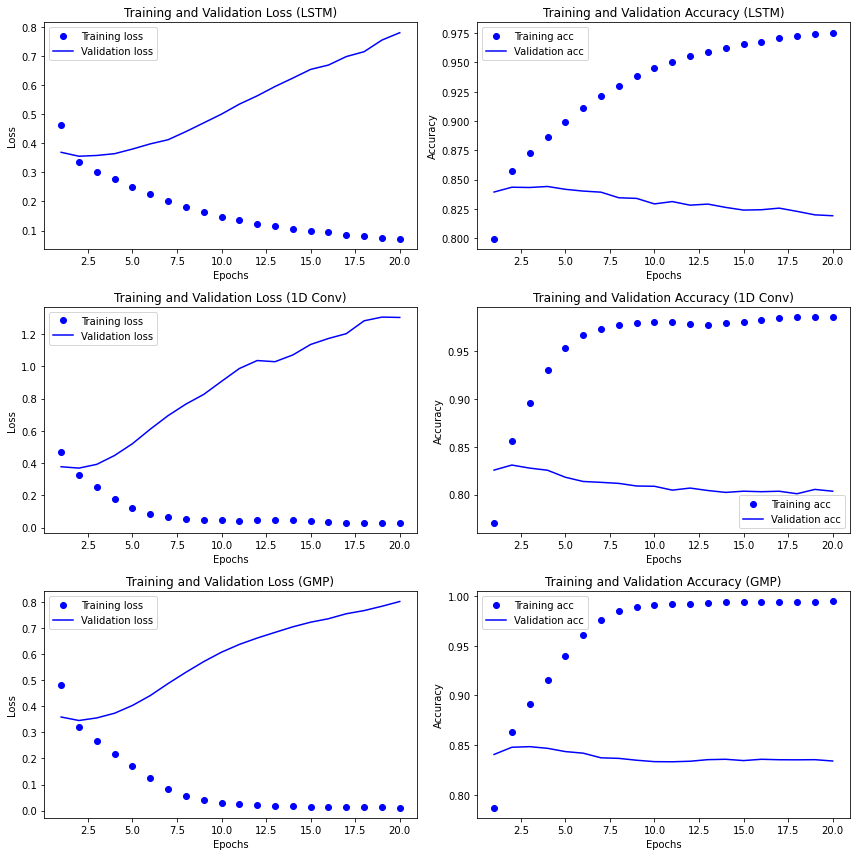

In [20]:
import matplotlib.pyplot as plt

# 평가 지표 출력

history_dict_LSTM = history_LSTM.history
history_dict_Conv1D = history_Conv1D.history
history_dict_GMP = history_GMP.history

# 데이터 정의
histories = [
    ("LSTM", history_dict_LSTM),
    ("1D Conv", history_dict_Conv1D),
    ("GMP", history_dict_GMP)
]

# 서브플롯 생성
fig, axes = plt.subplots(len(histories), 2, figsize=(12, 12))

for i, (model_name, history) in enumerate(histories):
    epochs = range(1, len(history['accuracy']) + 1)
    # Loss 플롯
    axes[i, 0].plot(epochs, history['loss'], 'bo', label='Training loss')
    axes[i, 0].plot(epochs, history['val_loss'], 'b', label='Validation loss')
    axes[i, 0].set_title(f'Training and Validation Loss ({model_name})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # Accuracy 플롯
    axes[i, 1].plot(epochs, history['accuracy'], 'bo', label='Training acc')
    axes[i, 1].plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
    axes[i, 1].set_title(f'Training and Validation Accuracy ({model_name})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### 학습된 임베딩 레이어 분석

In [21]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [22]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00885111, -0.02545463,  0.02326429,  0.15998356, -0.00705764,
       -0.02312258,  0.05775726, -0.09920873,  0.01408457, -0.03593665,
       -0.01149047, -0.00225736,  0.02717996, -0.10517484,  0.08996892,
        0.03726846, -0.05923285, -0.09006017, -0.02604373,  0.10339399,
        0.06604829,  0.02055752,  0.0148837 , -0.10007595, -0.01682387,
       -0.09395038, -0.04525855, -0.07146531, -0.07956684, -0.0728818 ,
        0.12357576, -0.10823471, -0.1047485 , -0.03141985,  0.06856441,
        0.00243936,  0.05245288, -0.02804573, -0.03977173, -0.01346807,
        0.03612856, -0.02980996,  0.06091936,  0.05574062, -0.06192444,
        0.00086669,  0.00597596,  0.05182539,  0.03093247, -0.09383611,
       -0.03020348,  0.13885313, -0.00781768,  0.03392277, -0.01085451,
       -0.0441591 ,  0.01384167, -0.08188138, -0.03132161, -0.07695301,
        0.01058756, -0.09429542, -0.04397864,  0.03253198,  0.11608312,
       -0.01031553,  0.01123713, -0.0377143 , -0.1217716 ,  0.01

In [24]:
print(list(word_vectors.key_to_index)[:50])

['영화', '다', '고', '하', '을', '보', '게', '지', '있', '없', '좋', '나', '었', '만', '는데', '너무', '봤', '적', '안', '정말', '로', '것', '음', '아', '네요', '어', '재밌', '지만', '같', '진짜', '에서', '했', '기', '네', '않', '점', '거', '았', '수', '되', '면', 'ㅋㅋ', '인', '말', '연기', '주', '최고', '내', '평점', '이런']


In [25]:
word_vectors.similar_by_word("끝")

[('안', 0.6263099312782288),
 ('아깝', 0.6184717416763306),
 ('스토리', 0.6154861450195312),
 ('아까움', 0.6009475588798523),
 ('이하', 0.5973334312438965),
 ('뻔한', 0.5936746001243591),
 ('웩', 0.5864841341972351),
 ('만드세요', 0.5844902396202087),
 ('병맛', 0.5838433504104614),
 ('지루함', 0.5819704532623291)]

word2vec 학습 전 결과 : 단어와 상관관계가 없는 단어들이 나옴

In [26]:
# Word2Vec_ko 모델
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [27]:
word_vectors.wv.similar_by_word("끝")

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

word2vec 학습 후 결과 : word2vec 학습 전보다 나아진 결과를 보임  
하지만 후 순위로 갈 수록 관련 없는 단어가 튀어나옴  
-> 이 모델은 긍정, 부정으로만 분류하기 때문에 단어 간 관계가 없어 보이는 단어가 나타날 수 있음 (뉘앙스만 보기)

## word2vec 모델을 이용하여 재학습

### 모델 1 : LSTM

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [29]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 36, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,007,777
Trainable params: 1,007,777
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_LSTM.keras",
                                    save_best_only=True)
]

history_LSTM = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/30
200/200 [==============================] - 3s 8ms/step - loss: 0.5675 - accuracy: 0.6976 - val_loss: 0.4632 - val_accuracy: 0.7831
Epoch 2/30
200/200 [==============================] - 1s 6ms/step - loss: 0.4196 - accuracy: 0.8083 - val_loss: 0.3994 - val_accuracy: 0.8196
Epoch 3/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3668 - accuracy: 0.8383 - val_loss: 0.3802 - val_accuracy: 0.8283
Epoch 4/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3379 - accuracy: 0.8546 - val_loss: 0.3684 - val_accuracy: 0.8362
Epoch 5/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3178 - accuracy: 0.8641 - val_loss: 0.3643 - val_accuracy: 0.8400
Epoch 6/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3024 - accuracy: 0.8723 - val_loss: 0.3683 - val_accuracy: 0.8399
Epoch 7/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2885 - accuracy: 0.8790 - val_loss: 0.3675 - val_accuracy: 0.8410
Epoch 

In [31]:
# 모델 평가

model_LSTM = keras.models.load_model("segmentation_LSTM.keras")
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3711 - accuracy: 0.8367
[0.3711423873901367, 0.8367068767547607]


### 모델 2 : 1D Convolution

In [32]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 6, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 16)            9616      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             3104      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [33]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_Conv1D.keras",
                                    save_best_only=True)
]

history_Conv1D = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/30
200/200 [==============================] - 2s 7ms/step - loss: 0.6718 - accuracy: 0.5573 - val_loss: 0.5698 - val_accuracy: 0.7034
Epoch 2/30
200/200 [==============================] - 1s 5ms/step - loss: 0.5120 - accuracy: 0.7502 - val_loss: 0.4702 - val_accuracy: 0.7753
Epoch 3/30
200/200 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.7973 - val_loss: 0.4321 - val_accuracy: 0.7962
Epoch 4/30
200/200 [==============================] - 1s 5ms/step - loss: 0.3944 - accuracy: 0.8211 - val_loss: 0.4110 - val_accuracy: 0.8077
Epoch 5/30
200/200 [==============================] - 1s 5ms/step - loss: 0.3653 - accuracy: 0.8372 - val_loss: 0.4008 - val_accuracy: 0.8143
Epoch 6/30
200/200 [==============================] - 1s 5ms/step - loss: 0.3451 - accuracy: 0.8482 - val_loss: 0.4051 - val_accuracy: 0.8130
Epoch 7/30
200/200 [==============================] - 1s 5ms/step - loss: 0.3258 - accuracy: 0.8591 - val_loss: 0.3962 - val_accuracy: 0.8195
Epoch 

In [34]:
# 모델 평가

model_Conv1D = keras.models.load_model("segmentation_Conv1D.keras")
results = model_Conv1D.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4042 - accuracy: 0.8169
[0.4042390286922455, 0.8168928027153015]


### 모델 3 : GMP

In [35]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 12)                1212      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 1,001,225
Trainable params: 1,001,225
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_GMP.keras",
                                    save_best_only=True)
]

history_GMP = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/30
200/200 [==============================] - 1s 5ms/step - loss: 0.7804 - accuracy: 0.5658 - val_loss: 0.6782 - val_accuracy: 0.6113
Epoch 2/30
200/200 [==============================] - 1s 4ms/step - loss: 0.6411 - accuracy: 0.6425 - val_loss: 0.6108 - val_accuracy: 0.6686
Epoch 3/30
200/200 [==============================] - 1s 4ms/step - loss: 0.5981 - accuracy: 0.6793 - val_loss: 0.5818 - val_accuracy: 0.6945
Epoch 4/30
200/200 [==============================] - 1s 4ms/step - loss: 0.5716 - accuracy: 0.6998 - val_loss: 0.5596 - val_accuracy: 0.7112
Epoch 5/30
200/200 [==============================] - 1s 4ms/step - loss: 0.5488 - accuracy: 0.7189 - val_loss: 0.5462 - val_accuracy: 0.7179
Epoch 6/30
200/200 [==============================] - 1s 4ms/step - loss: 0.5286 - accuracy: 0.7340 - val_loss: 0.5269 - val_accuracy: 0.7362
Epoch 7/30
200/200 [==============================] - 1s 4ms/step - loss: 0.5113 - accuracy: 0.7466 - val_loss: 0.5134 - val_accuracy: 0.7457
Epoch 

In [37]:
# 모델 평가

model_GMP = keras.models.load_model("segmentation_GMP.keras")
results = model_GMP.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4360 - accuracy: 0.8041
[0.43596184253692627, 0.804097056388855]


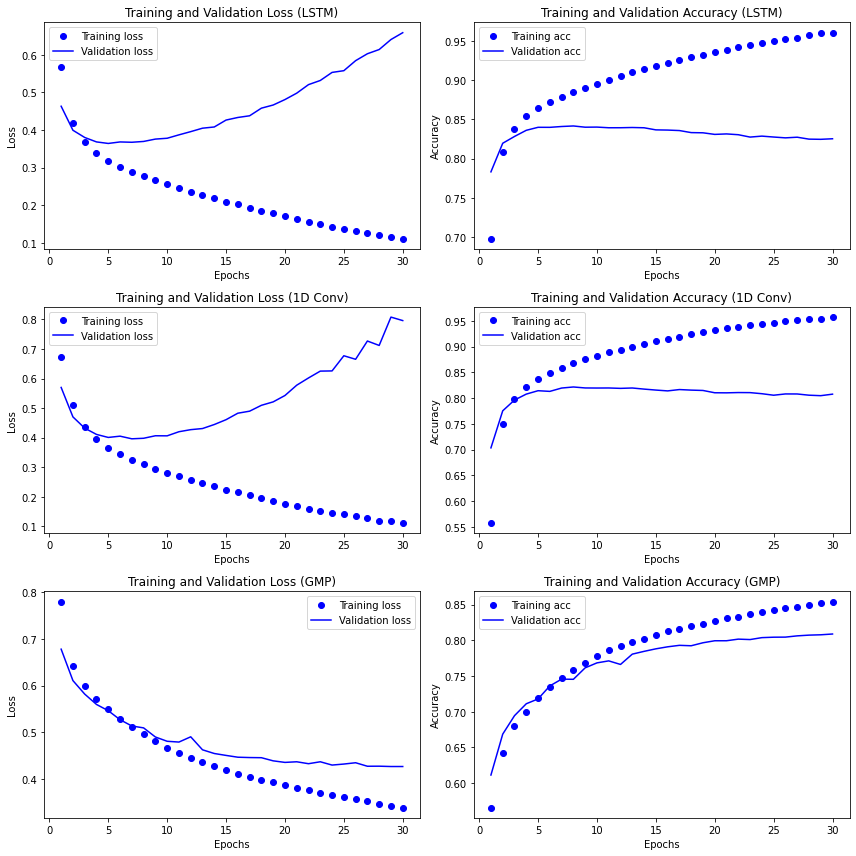

In [38]:
import matplotlib.pyplot as plt

# 평가 지표 출력

history_dict_LSTM = history_LSTM.history
history_dict_Conv1D = history_Conv1D.history
history_dict_GMP = history_GMP.history

# 데이터 정의
histories = [
    ("LSTM", history_dict_LSTM),
    ("1D Conv", history_dict_Conv1D),
    ("GMP", history_dict_GMP)
]

# 서브플롯 생성
fig, axes = plt.subplots(len(histories), 2, figsize=(12, 12))

for i, (model_name, history) in enumerate(histories):
    epochs = range(1, len(history['accuracy']) + 1)
    # Loss 플롯
    axes[i, 0].plot(epochs, history['loss'], 'bo', label='Training loss')
    axes[i, 0].plot(epochs, history['val_loss'], 'b', label='Validation loss')
    axes[i, 0].set_title(f'Training and Validation Loss ({model_name})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # Accuracy 플롯
    axes[i, 1].plot(epochs, history['accuracy'], 'bo', label='Training acc')
    axes[i, 1].plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
    axes[i, 1].set_title(f'Training and Validation Accuracy ({model_name})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

## LSTM 파라미터 조정하기

순환드롭아웃 적용

In [75]:
# from tensorflow.keras.initializers import Constant

# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 100  # 워드 벡터의 차원 수 

# # 모델 구성
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, 
#                                  word_vector_dim, 
#                                  embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                  input_length=maxlen, 
#                                  trainable=True))   # trainable을 True로 주면 Fine-tuning
# model.add(tf.keras.layers.LSTM(32,recurrent_dropout=0.25))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 36, 100)           1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 1,018,113
Trainable params: 1,018,113
Non-trainable params: 0
_________________________________________________________________


In [76]:
# # 학습 진행
# model.compile(optimizer='RMSprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
              
# epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# callbacks = [
#     keras.callbacks.ModelCheckpoint("segmentation_LSTM.keras",
#                                     save_best_only=True)
# ]

# history_LSTM = model.fit(partial_x_train, partial_y_train,
#                     epochs=epochs,
#                     callbacks=callbacks,
#                     batch_size=512,
#                     validation_data=(x_val, y_val))

Epoch 1/10
200/200 [==============================] - 26s 119ms/step - loss: 0.5291 - accuracy: 0.7295 - val_loss: 0.4499 - val_accuracy: 0.7911
Epoch 2/10
200/200 [==============================] - 23s 117ms/step - loss: 0.4285 - accuracy: 0.8029 - val_loss: 0.4006 - val_accuracy: 0.8178
Epoch 3/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3832 - accuracy: 0.8269 - val_loss: 0.3831 - val_accuracy: 0.8264
Epoch 4/10
200/200 [==============================] - 24s 119ms/step - loss: 0.3549 - accuracy: 0.8434 - val_loss: 0.3622 - val_accuracy: 0.8388
Epoch 5/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3342 - accuracy: 0.8537 - val_loss: 0.3587 - val_accuracy: 0.8412
Epoch 6/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3191 - accuracy: 0.8612 - val_loss: 0.3488 - val_accuracy: 0.8464
Epoch 7/10
200/200 [==============================] - 24s 119ms/step - loss: 0.3068 - accuracy: 0.8673 - val_loss: 0.3466 - val_ac

In [77]:
# # 모델 평가

# model_LSTM = keras.models.load_model("segmentation_LSTM.keras")
# results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

# print(results)

1537/1537 - 15s - loss: 0.3506 - accuracy: 0.8471
[0.3506002724170685, 0.8471428155899048]


84.71%에서 올라가지 않음. (속도가 너무 느려서 신중하게 시도해야 함)

2차 시도 (LSTM 층 추가)

In [99]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64, return_sequences=True)) #첫 번째 LSTM 층의 출력이 다음 LSTM 층으로 전달되도록 설정.
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(518, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 36, 100)           1000000   
_________________________________________________________________
lstm_24 (LSTM)               (None, 36, 64)            42240     
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_65 (Dense)             (None, 518)               17094     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 519       
Total params: 1,072,269
Trainable params: 1,072,269
Non-trainable params: 0
_________________________________________________________________


In [100]:
# 학습 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation_LSTM.keras",
                                    save_best_only=True)
]

history_LSTM = model.fit(partial_x_train, partial_y_train,
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
200/200 [==============================] - 5s 12ms/step - loss: 0.5034 - accuracy: 0.7478 - val_loss: 0.4168 - val_accuracy: 0.8095
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3952 - accuracy: 0.8195 - val_loss: 0.3723 - val_accuracy: 0.8315
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3507 - accuracy: 0.8432 - val_loss: 0.3471 - val_accuracy: 0.8464
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3209 - accuracy: 0.8594 - val_loss: 0.3379 - val_accuracy: 0.8506
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.3004 - accuracy: 0.8696 - val_loss: 0.3402 - val_accuracy: 0.8534
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2825 - accuracy: 0.8792 - val_loss: 0.3390 - val_accuracy: 0.8542
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2672 - accuracy: 0.8865 - val_loss: 0.3424 - val_accuracy: 0.8516
Epoch

In [101]:
# 모델 평가

model_LSTM = keras.models.load_model("segmentation_LSTM.keras")
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3466 - accuracy: 0.8524
[0.3466168940067291, 0.8524320125579834]


정확도 85% 달성을 확인!

## 회고  

정확도 85%를 맞추기 위해서 여러 방법을 시도하였다.  
우선 은닉층의 노드의 조합을 변경하는 것에는 한계가 있었다.  
또한 Dense층을 늘리는 시도도 효과가 있지 않았다.
위의 2가지에만 집중해서 헤메는 시간이 오래 걸렸던 것이 아쉽다.  
다음 프로젝트에서는 텍스트 데이터 모델을 더 효율적으로 쓰는 방법을 알아야겠다는 생각이 든다.